# Титаник: класификация, data exploration, feature engineering

Днес:

* Ще разгледаме един от култовите dataset-и в Kaggle: titanic
* Ще пробваме няколко класификационни алгоритми
* Ще ровим в данните и ще измислим няколко feature-а за да подобрим модела

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import mglearn

from IPython.display import display

%matplotlib inline

# Преди това

Да погледнем малко pandas.

# Pandas

`pandas` е библиотека с добри инструменти за data science. Има доста възможности, но най-ключовоте неща в нея (за нашите цели) е `DataFrame` обекта. Това е таблица с данни, с която може да изпълняваме интересни операции. `DataFrame`-овете работят добре с scikit-learn – може да ги подавате директно на моделите.

In [2]:
characters = \
  pd.DataFrame([["John Snow", "male", 16, 3, 2],
                ["Arya Stark", "female", 11, 4, 1],
                ["Daenerys Targeryan", "female", 16, 2, 1],
                ["Jamie Lannister", "male", 36, 1, 1]
               ], columns=['Name', 'Gender', 'Age', 'Brothers', 'Sisters'])
    
characters

,Name,Gender,Age,Brothers,Sisters
0,John Snow,male,16,3,2
1,Arya Stark,female,11,4,1
2,Daenerys Targeryan,female,16,2,1
3,Jamie Lannister,male,36,1,1


Може да видим малко информация за този data frame:

In [3]:
characters.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4 entries, 0 to 3
Data columns (total 5 columns):
Name        4 non-null object
Gender      4 non-null object
Age         4 non-null int64
Brothers    4 non-null int64
Sisters     4 non-null int64
dtypes: int64(3), object(2)
memory usage: 240.0+ bytes


Обърнете внимане, че всяка колона има отделен тип.

Може да създадете `DataFrame` и с речник:

In [4]:
characters = \
  pd.DataFrame({
    'Name': ['John Snow', 'Arya Stark', 'Daenerys Targeryan', 'Jamie Lannister'],
    'Gender': pd.Categorical(['male', 'female', 'female', 'male']),
    'Age': [16, 11, 16, 36],
    'Brothers': [3, 4, 2, 1],
    'Sisters': [2, 1, 1, 1],
  }, columns=['Name', 'Gender', 'Age', 'Brothers', 'Sisters'])

characters

,Name,Gender,Age,Brothers,Sisters
0,John Snow,male,16,3,2
1,Arya Stark,female,11,4,1
2,Daenerys Targeryan,female,16,2,1
3,Jamie Lannister,male,36,1,1


Тук имаме леко различни типове:

In [5]:
characters.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4 entries, 0 to 3
Data columns (total 5 columns):
Name        4 non-null object
Gender      4 non-null category
Age         4 non-null int64
Brothers    4 non-null int64
Sisters     4 non-null int64
dtypes: category(1), int64(3), object(1)
memory usage: 308.0+ bytes


Има тон забавни операции. Например филтриране:

In [6]:
characters[characters.Age < 20]

,Name,Gender,Age,Brothers,Sisters
0,John Snow,male,16,3,2
1,Arya Stark,female,11,4,1
2,Daenerys Targeryan,female,16,2,1


Може да видим статистика за някои от колоните:

In [7]:
characters.describe()

,Age,Brothers,Sisters
count,4.000000,4.000000,4.00
mean,19.750000,2.500000,1.25
std,11.086779,1.290994,0.50
min,11.000000,1.000000,1.00
25%,14.750000,1.750000,1.00
50%,16.000000,2.500000,1.00
75%,21.000000,3.250000,1.25
max,36.000000,4.000000,2.00


Обърнете внимание, че това показва само числовите колони

Може да сортирате:

In [8]:
characters.sort_values(by=['Age', 'Name'])

,Name,Gender,Age,Brothers,Sisters
1,Arya Stark,female,11,4,1
2,Daenerys Targeryan,female,16,2,1
0,John Snow,male,16,3,2
3,Jamie Lannister,male,36,1,1


Може да направите импровизиран one-hot encoding:

In [9]:
encoded = characters.copy()
encoded['Male'] = (encoded.Gender == 'male').astype(float)
encoded['Female'] = (encoded.Gender == 'female').astype(float)
encoded

,Name,Gender,Age,Brothers,Sisters,Male,Female
0,John Snow,male,16,3,2,1.0,0.0
1,Arya Stark,female,11,4,1,0.0,1.0
2,Daenerys Targeryan,female,16,2,1,0.0,1.0
3,Jamie Lannister,male,36,1,1,1.0,0.0


Можете дори да си направите нова колона като функция от други колони:

In [10]:
extended = characters.copy()
extended['Siblings'] = extended.Brothers + extended.Sisters
extended

,Name,Gender,Age,Brothers,Sisters,Siblings
0,John Snow,male,16,3,2,5
1,Arya Stark,female,11,4,1,5
2,Daenerys Targeryan,female,16,2,1,3
3,Jamie Lannister,male,36,1,1,2


# Titanic

Titanic е първия dataset с който ще се сблъскате в Kaggle. Може да го изтеглите от тук:

https://www.kaggle.com/c/titanic

Данните съдържат историческата информация за пътниците (възраст, пол, име, т.н.) на кораба, както и label-и дали са оцелели.

Отговаряме на класификационнен въпрос. Именно:

Кой от тези двамата ще умре?

![titanic.jpeg](https://www.movieposter.com/posters/archive/main/142/MPW-71146)

Да започнем със зареждане на dataset-а. Ползваме `pandas`.

Първо, ще ограничим колко реда се показват до 15 (за да се събират в слайдовете):

In [11]:
pd.options.display.max_rows = 15

След това зареждаме данните:

In [12]:
pd.read_csv('data/titanic/train.csv')

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
...,...,...,...,...,...,...,...,...,...,...,...,...
884,885,0,3,"Sutehall, Mr. Henry Jr",male,25.0,0,0,SOTON/OQ 392076,7.0500,NaN,S
885,886,0,3,"Rice, Mrs. William (Margaret Norton)",female,39.0,0,5,382652,29.1250,NaN,Q


`PassengerId` изглежда като иднекс, който няма да ни даде нищо интересно. Може да отрежем колоната, но pandas има трик за целта:

In [13]:
original = pd.read_csv('data/titanic/train.csv', index_col='PassengerId')
original

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
...,...,...,...,...,...,...,...,...,...,...,...
885,0,3,"Sutehall, Mr. Henry Jr",male,25.0,0,0,SOTON/OQ 392076,7.0500,NaN,S


Какво ли значат тези данни? Може да видим в Kaggle:

| Variable | Definition                                 | Key                                            |
|:---------|:-------------------------------------------|:-----------------------------------------------|
| Survived | Survival                                   | 0 = No, 1 = Yes                                |
| Pclass   | Ticket class                               | 1 = 1st, 2 = 2nd, 3 = 3rd                      |
| Sex      | Sex                                        |                                                |
| Age      | Age in years                               |                                                |
| SibSp    | # of siblings / spouses aboard the Titanic |                                                |
| Parch    | # of parents / children aboard the Titanic |                                                |
| Ticket   | Ticket number                              |                                                |
| Fare     | Passenger fare                             |                                                |
| Cabin    | Cabin number                               |                                                |
| Embarked | Port of Embarkation                        | C = Cherbourg, Q = Queenstown, S = Southampton |


Да видим малко статистика:

In [14]:
original.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Забелязва се, че не всички колони имат стойности - например Age. Нека да видим какво е положението при другите:

In [15]:
original.isnull().sum().sort_values()

Survived      0
Pclass        0
Name          0
Sex           0
SibSp         0
Parch         0
Ticket        0
Fare          0
Embarked      2
Age         177
Cabin       687
dtype: int64

Трябва да решим този проблем. Анализът ни на трите колони е следния:

* Липсват само две `Embarked` – може да ги попълним както си искаме, няма да има голямо значение.
* Повечето `Cabin` липсват – едва ли може да извлечем интересна информация от там (ако не се постараем твърде много) и може да игнорираме колоната
* `Age` вече е проблем – трябва да изберем какво да направим.

## Обработка на Age

Опциите ни са:

1. Да разкараме редовете
2. Да попълним с нули
3. Да попълним със средната стойност на колоната
4. Да направим някаква магия

1 не е опция, понеже ще загубим около 20% от данните. Dataset-а е малък. 2 също не е най-доброто решение, понеже ще измести данните твърде много в една посока. Понеже още не сме магьосници, ще почнем с 3.

In [16]:
data = original.copy()
data['Age'] = data.Age.fillna(data.Age.mean())
data

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.000000,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000000,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.000000,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000000,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.000000,0,0,373450,8.0500,NaN,S
6,0,3,"Moran, Mr. James",male,29.699118,0,0,330877,8.4583,NaN,Q
7,0,1,"McCarthy, Mr. Timothy J",male,54.000000,0,0,17463,51.8625,E46,S
...,...,...,...,...,...,...,...,...,...,...,...
885,0,3,"Sutehall, Mr. Henry Jr",male,25.000000,0,0,SOTON/OQ 392076,7.0500,NaN,S


Да видим какво стана:

In [17]:
data.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,13.002015,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,22.000000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,29.699118,0.000000,0.000000,14.454200
75%,1.000000,3.000000,35.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Чудесно! Нека започнем с baseline модел.

# Baseline модел

За начало ще пробваме да baseline тренираме модел само с числовите колони. Веднъж като имаме отправна точка, ще пробваме да подобрим нещата с още feature-и:

In [18]:
X = data[['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']]
y = data['Survived']

In [19]:
X

,Pclass,Age,SibSp,Parch,Fare
PassengerId,,,,,
1,3,22.000000,1,0,7.2500
2,1,38.000000,1,0,71.2833
3,3,26.000000,0,0,7.9250
4,1,35.000000,1,0,53.1000
5,3,35.000000,0,0,8.0500
6,3,29.699118,0,0,8.4583
7,1,54.000000,0,0,51.8625
...,...,...,...,...,...
885,3,25.000000,0,0,7.0500


In [20]:
y

PassengerId
1      0
2      1
3      1
4      1
5      0
6      0
7      0
      ..
885    0
886    0
887    0
888    1
889    0
890    1
891    0
Name: Survived, Length: 891, dtype: int64

Нека погледнем колко човека са оцелели:

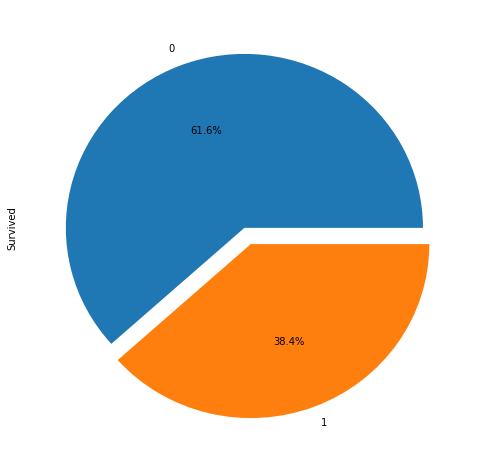

In [21]:
y.value_counts().plot.pie(explode=[0, 0.1], figsize=(8, 8), autopct='%1.1f%%');

Обърнете внимане, че класовете не са 50/50.

Нека си отделим тренировъчен модел:

In [22]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, stratify=y)

Ползваме `stratify` за да се уверим, че `y_train` и `y_test` запазват пропорциите:

In [23]:
y_train.mean()

0.38323353293413176

In [24]:
y_test.mean()

0.38565022421524664

Ще се пробваме първоначално с логичстична регресия:

In [25]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression().fit(X_train, y_train)
print("train score:", model.score(X_train, y_train))
print("test score: ", model.score(X_test, y_test))

train score: 0.708083832335
test score:  0.695067264574


Виждаме, че модела се справя учудващо добре с толкова малко данни и не overfit-ва. Все пак, има голямо поле за подобрение.

Да пробваме и с random forest:

In [26]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(random_state=0).fit(X_train, y_train)
print("train score:", model.score(X_train, y_train))
print("test score: ", model.score(X_test, y_test))

train score: 0.943113772455
test score:  0.686098654709


Тук вече има голям overfit. Може да се опитаме да регуляризираме. По принцип няма смисъл на този етап, но нека да демонстрираме Grid Search:

In [27]:
from sklearn.model_selection import GridSearchCV

search = GridSearchCV(model, {'n_estimators': [10, 30, 50, 70, 100],
                              'max_depth': [2, 4, 6, 8, 10, 12, 15]})
search.fit(X, y)

pd.DataFrame(search.cv_results_)[['rank_test_score', 'mean_test_score', 'params']].sort_values(by='rank_test_score').head(10)

,rank_test_score,mean_test_score,params
14,1,0.735129,"{'max_depth': 6, 'n_estimators': 100}"
8,2,0.727273,"{'max_depth': 4, 'n_estimators': 70}"
9,2,0.727273,"{'max_depth': 4, 'n_estimators': 100}"
12,2,0.727273,"{'max_depth': 6, 'n_estimators': 50}"
11,5,0.726150,"{'max_depth': 6, 'n_estimators': 30}"
7,5,0.726150,"{'max_depth': 4, 'n_estimators': 50}"
10,5,0.726150,"{'max_depth': 6, 'n_estimators': 10}"
13,5,0.726150,"{'max_depth': 6, 'n_estimators': 70}"
6,9,0.722783,"{'max_depth': 4, 'n_estimators': 30}"
18,10,0.720539,"{'max_depth': 8, 'n_estimators': 70}"


Изглежда, че няма да видим много драматчина разлика.

Резултати са малко по-подробни, може да ги разгледате:

In [28]:
pd.DataFrame(search.cv_results_).sort_values(by='rank_test_score')

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_max_depth,param_n_estimators,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
14,0.114471,0.008045,0.735129,0.797419,6,100,"{'max_depth': 6, 'n_estimators': 100}",1,0.696970,0.824916,0.734007,0.794613,0.774411,0.772727,0.002957,0.000114,0.031625,0.021398
8,0.074322,0.004869,0.727273,0.756453,4,70,"{'max_depth': 4, 'n_estimators': 70}",2,0.676768,0.776094,0.730640,0.759259,0.774411,0.734007,0.000339,0.000047,0.039934,0.017296
9,0.109834,0.008396,0.727273,0.758137,4,100,"{'max_depth': 4, 'n_estimators': 100}",2,0.680135,0.782828,0.734007,0.754209,0.767677,0.737374,0.002714,0.001067,0.036055,0.018763
12,0.057093,0.004989,0.727273,0.791807,6,50,"{'max_depth': 6, 'n_estimators': 50}",2,0.703704,0.814815,0.720539,0.792929,0.757576,0.767677,0.000368,0.000265,0.022503,0.019260
11,0.034545,0.002903,0.726150,0.791807,6,30,"{'max_depth': 6, 'n_estimators': 30}",5,0.690236,0.823232,0.727273,0.786195,0.760943,0.765993,0.000415,0.000386,0.028877,0.023702
7,0.055777,0.004556,0.726150,0.759820,4,50,"{'max_depth': 4, 'n_estimators': 50}",5,0.680135,0.784512,0.723906,0.760943,0.774411,0.734007,0.000995,0.000517,0.038521,0.020634
10,0.012081,0.001232,0.726150,0.793490,6,10,"{'max_depth': 6, 'n_estimators': 10}",5,0.686869,0.835017,0.730640,0.771044,0.760943,0.774411,0.000223,0.000049,0.030407,0.029396
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25,0.013110,0.001428,0.696970,0.913019,12,10,"{'max_depth': 12, 'n_estimators': 10}",29,0.680135,0.936027,0.696970,0.897306,0.713805,0.905724,0.000292,0.000080,0.013746,0.016628
33,0.089083,0.006653,0.695847,0.959596,15,70,"{'max_depth': 15, 'n_estimators': 70}",30,0.690236,0.959596,0.696970,0.961279,0.700337,0.957912,0.000382,0.000354,0.004199,0.001375


Нека тренираме модел с най-добрите параметри:

In [29]:
model = RandomForestClassifier(max_depth=6, n_estimators=100, random_state=0).fit(X_train, y_train)
print("train score:", model.score(X_train, y_train))
print("test score: ", model.score(X_test, y_test))

train score: 0.782934131737
test score:  0.713004484305


Това е малко по-добре, но като цяло беше безсмислено упражнение. Да продължим напред!

Да се върнем на dataset-а.

Каква според вас е следващата стъпка?

# Data exploration

Нека погледнем какви feature-и не ползваме:

| Variable       | Definition                                   | Key                                              |
| :------------- | :------------------------------------------- | :----------------------------------------------- |
| **Survived**   | Survival                                     | 0 = No, 1 = Yes                                  |
| Name           | Name of the passenger                        |                                                  |
| **Pclass**     | Ticket class                                 | 1 = 1st, 2 = 2nd, 3 = 3rd                        |
| Sex            | Sex                                          |                                                  |
| **Age**        | Age in years                                 |                                                  |
| **SibSp**      | # of siblings / spouses aboard the Titanic   |                                                  |
| **Parch**      | # of parents / children aboard the Titanic   |                                                  |
| Ticket         | Ticket number                                |                                                  |
| **Fare**       | Passenger fare                               |                                                  |
| Cabin          | Cabin number                                 |                                                  |
| Embarked       | Port of Embarkation                          | C = Cherbourg, Q = Queenstown, S = Southampton   |

Използваните feature-и са в **получер**.

`Sex` е много интересен feature. Вероятно политиката е била "първо жените и децата". Нека да видим дали има корелация между пола и това дали са оцелели:

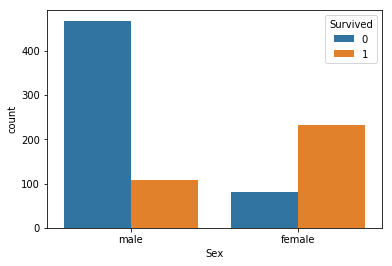

In [30]:
sns.countplot('Sex', hue='Survived', data=data);

Определено има нещо тук.

Казахме "първо жените и децата". Нека да видим и как изглежда това с възрастта:

За да е по-лесно ще ги групираме в групи от 5 (0–5, 5-10, 10-15, и т.н.):

In [31]:
ages = original[['Survived', 'Age']]
ages = ages[~ages.Age.isnull()]
ages.Age = ages.Age.apply(lambda x: (x // 5) * 5)

Нека да изчислим успеваемостта във всяка възрастова група от по две години:

In [32]:
ages.groupby('Age').mean()

,Survived
Age,
0.0,0.675000
5.0,0.500000
10.0,0.437500
15.0,0.395349
20.0,0.342105
25.0,0.358491
30.0,0.421053
...,...
45.0,0.390244


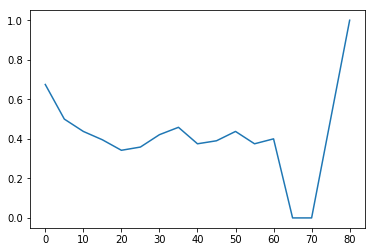

In [33]:
plt.plot(ages.groupby('Age').mean());

Май се наблюдава някаква тенденция, но защо графиката скача към 1.0 при 80?

In [34]:
original[original.Age >= 70][['Survived', 'Name', 'Age']].sort_values(by='Age', ascending=False)

,Survived,Name,Age
PassengerId,,,
631,1,"Barkworth, Mr. Algernon Henry Wilson",80.0
852,0,"Svensson, Mr. Johan",74.0
97,0,"Goldschmidt, Mr. George B",71.0
494,0,"Artagaveytia, Mr. Ramon",71.0
117,0,"Connors, Mr. Patrick",70.5
673,0,"Mitchell, Mr. Henry Michael",70.0
746,0,"Crosby, Capt. Edward Gifford",70.0


Аха – outlier! Най-възрастния пътник е оцелял. Интересно.

Я да видим как изглеждат нещата в `Pclass`:

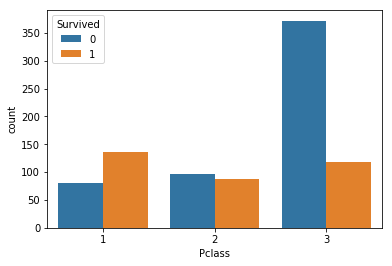

In [35]:
sns.countplot('Pclass', hue='Survived', data=original);

Явно това да си богат помага – пътниците от първа класа имат много по-голям шанс да оцелят от тези в трета.

Полезна информация, нека си вземем бележка.

Нека съпоставим това и с пола:

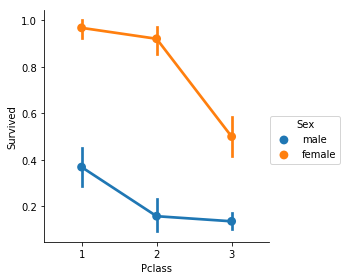

In [36]:
sns.factorplot('Pclass', 'Survived', hue='Sex', data=original);

Жените от първа класа имат шанс да оцелеят почти $1.0$!

Да видим дали има нещо интересно в `Embarked`.

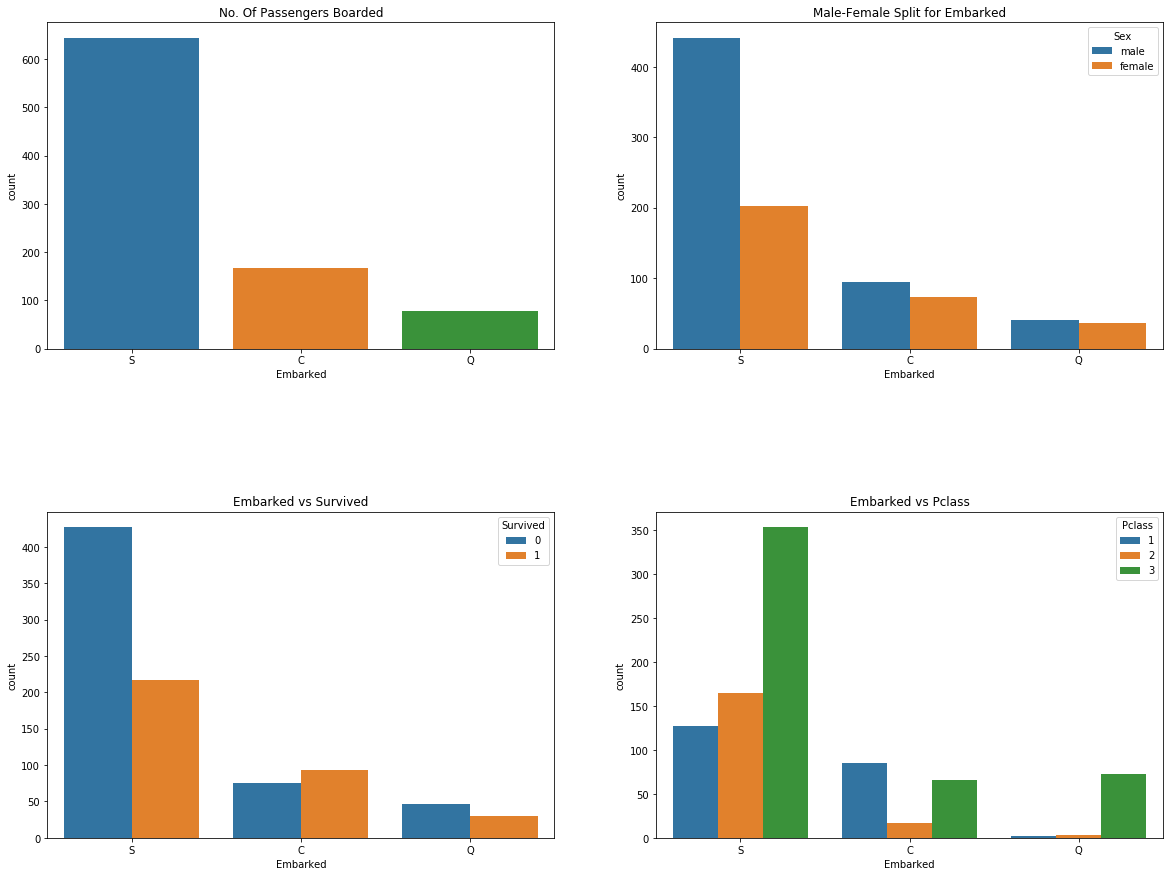

In [37]:
f, ax = plt.subplots(2, 2, figsize=(20,15))

sns.countplot('Embarked', data=original, ax=ax[0,0])
ax[0, 0].set_title('No. Of Passengers Boarded')

sns.countplot('Embarked', hue='Sex', data=original, ax=ax[0,1])
ax[0, 1].set_title('Male-Female Split for Embarked')

sns.countplot('Embarked', hue='Survived', data=original, ax=ax[1,0])
ax[1, 0].set_title('Embarked vs Survived')

sns.countplot('Embarked', hue='Pclass', data=original, ax=ax[1,1])
ax[1, 1].set_title('Embarked vs Pclass')

plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

Виждамe, че хората качили се в Cherbourg имат по-добри шансове за оцеляване. Но ако се загледаме по-внимателно, ще забележим, че там са се качили най-много хора от първа класа. Т.е., това същестува корелация между двете. Може би това не е толкова интересно, но може да го пробваме.

Да разгледаме `Parch` и `SibSp`.

`SibSp` съдържа броя братя, сестри и половинки.

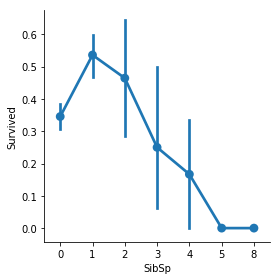

In [38]:
sns.factorplot('SibSp', 'Survived', data=original);

Вижда се, че хората пътуващи с роднини имат по-добри шансове. В това има логика, понеже всеки може да се опита да спаси роднините си преди да спаси себе си.

Да видим `Parch` (родители + деца):

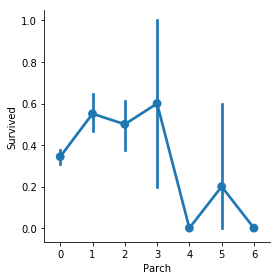

In [39]:
sns.factorplot('Parch', 'Survived', data=original);

Тук има нещо подобно. Дали няма смисъл от нов feature – family size?

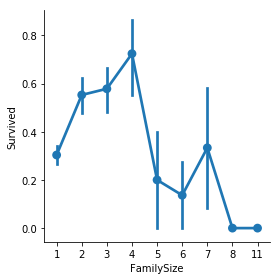

In [40]:
data = original.copy()
data['FamilySize'] = data['Parch'] + data['SibSp'] + 1
sns.factorplot('FamilySize', 'Survived', data=data);

Със сигурност виждаме, че хората пътували сами имат сериозно по-малък шанс от малки семейства (2 - 4). Има някаква аномалия покрай 7.

In [41]:
data[data.FamilySize == 7].sort_values(by='Name')

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize
PassengerId,,,,,,,,,,,,
851,0,3,"Andersson, Master. Sigvard Harald Elias",male,4.0,4,2,347082,31.2750,NaN,S,7
814,0,3,"Andersson, Miss. Ebba Iris Alfrida",female,6.0,4,2,347082,31.2750,NaN,S,7
120,0,3,"Andersson, Miss. Ellis Anna Maria",female,2.0,4,2,347082,31.2750,NaN,S,7
69,1,3,"Andersson, Miss. Erna Alexandra",female,17.0,4,2,3101281,7.9250,NaN,S,7
542,0,3,"Andersson, Miss. Ingeborg Constanzia",female,9.0,4,2,347082,31.2750,NaN,S,7
543,0,3,"Andersson, Miss. Sigrid Elisabeth",female,11.0,4,2,347082,31.2750,NaN,S,7
14,0,3,"Andersson, Mr. Anders Johan",male,39.0,1,5,347082,31.2750,NaN,S,7
611,0,3,"Andersson, Mrs. Anders Johan (Alfrida Konstant...",female,39.0,1,5,347082,31.2750,NaN,S,7
183,0,3,"Asplund, Master. Clarence Gustaf Hugo",male,9.0,4,2,347077,31.3875,NaN,S,7


Добре, тук виждаме, че семейство Asplund (шведи?) са имали късмет.

Всъщност, гледайки имената, всички изглеждат скандинавци, но това със сигуроност е произволно (не може да си извадим извода, че всички 7-членни семейства са скандинавци). Вероятно и в сем. Asplund има двама с други фамилии и затова не излизат тук.

До момента:

* Видяхме, че `Sex` е много определящ фактор.
* Аналогичен случай с `Age`, макар и не толкова произнесен.
* Класата също носи полезна информация.
* Размера на семейството също дава предимвство в определени точки.


Някой сеща ли се за друг атрибут, който не сме погледнали?

| Variable  | Definition                                   | Key                                              |
| :-------- | :------------------------------------------- | :----------------------------------------------- |
| Survived  | Survival                                     | 0 = No, 1 = Yes                                  |
| Name      | Name of the passenger                        |                                                  |
| Pclass    | Ticket class                                 | 1 = 1st, 2 = 2nd, 3 = 3rd                        |
| Sex       | Sex                                          |                                                  |
| Age       | Age in years                                 |                                                  |
| SibSp     | # of siblings / spouses aboard the Titanic   |                                                  |
| Parch     | # of parents / children aboard the Titanic   |                                                  |
| Ticket    | Ticket number                                |                                                  |
| Fare      | Passenger fare                               |                                                  |
| Cabin     | Cabin number                                 |                                                  |
| Embarked  | Port of Embarkation                          | C = Cherbourg, Q = Queenstown, S = Southampton   |



Да видим какво има в името:

In [42]:
original[['Name']].head(10)

,Name
PassengerId,
1,"Braund, Mr. Owen Harris"
2,"Cumings, Mrs. John Bradley (Florence Briggs Th..."
3,"Heikkinen, Miss. Laina"
4,"Futrelle, Mrs. Jacques Heath (Lily May Peel)"
5,"Allen, Mr. William Henry"
6,"Moran, Mr. James"
7,"McCarthy, Mr. Timothy J"
8,"Palsson, Master. Gosta Leonard"
9,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)"


Някой вижда ли нещо?

Тази титла може би е интересна. Дали не може да съобразим нещо от нея?

In [43]:
data['Title'] = data.Name.str.extract('([A-Za-z]+)\.', expand=False)

pd.options.display.max_rows = 20
data['Title'].value_counts()

Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Major         2
Mlle          2
Col           2
Mme           1
Lady          1
Jonkheer      1
Sir           1
Countess      1
Capt          1
Don           1
Ms            1
Name: Title, dtype: int64

Тук наистина има нещо интересно. Някои от тези титли се повтарят, а други да доста рядки за да има значение. Ще ги обраборим малко, но преди това, искам да видя дали докторите и свещенниците са имали по-голям шанс да оцелеят от останалите:

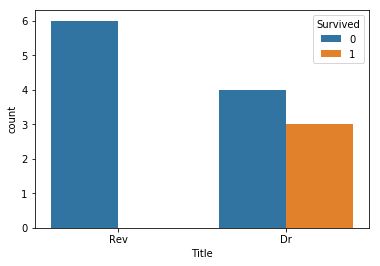

In [44]:
sns.countplot('Title', hue='Survived', data=data[data.Title.isin(['Dr', 'Rev'])]);

Явно всички вярващи са се срещнали с техния бог тази вечер. Данните са твърде малки и може да ги игнорираме. Нека сведем титлите пет вида.

Нека да посъберем титлите. Първо, малко френски (и правописни грешки):

In [45]:
data.loc[data.Title == 'Mlle', 'Title'] = 'Miss'
data.loc[data.Title == 'Mme', 'Title']  = 'Mrs'
data.loc[data.Title == 'Ms', 'Title']   = 'Miss'

In [46]:
data.Title.value_counts()

Mr          517
Miss        185
Mrs         126
Master       40
Dr            7
Rev           6
Major         2
Col           2
Sir           1
Capt          1
Don           1
Countess      1
Jonkheer      1
Lady          1
Name: Title, dtype: int64

Сега да махнем и останалите:

In [47]:
rare_titles = ['Dr', 'Rev', 'Col', 'Major', 'Countess', 'Don', 'Jonkheer', 'Capt', 'Lady', 'Sir']
data.Title = data.Title.replace(rare_titles, 'Rare')
data.Title.value_counts()

Mr        517
Miss      185
Mrs       126
Master     40
Rare       23
Name: Title, dtype: int64

Дали в титлата има полезна информация?

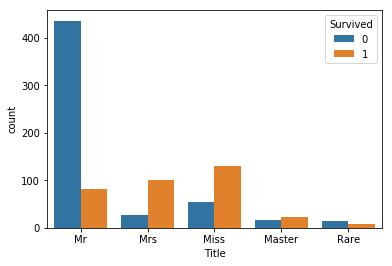

In [48]:
sns.countplot('Title', hue='Survived', data=data);

Идея – дали не може да ползваме титлата да си попълним възрастта?

In [49]:
age_by_title = data.groupby('Title').Age.mean()
age_by_title

Title
Master     4.574167
Miss      21.845638
Mr        32.368090
Mrs       35.788991
Rare      45.545455
Name: Age, dtype: float64

Това изглежда подходящо!

# Enough – следва feature engineering

Разгледахме данните достатъчно. Нека започнем начисто и да си попълним данните с новите feature-и които открихме.

Оригиналните данни бяха в `original`. Нека попълним титлите отново.

In [50]:
data = original.copy()

data['Title'] = data.Name.str.extract('([A-Za-z]+)\.', expand=False)
data.loc[data.Title == 'Mlle', 'Title'] = 'Miss'
data.loc[data.Title == 'Mme', 'Title']  = 'Mrs'
data.loc[data.Title == 'Ms', 'Title']   = 'Miss'

rare_titles = ['Dr', 'Rev', 'Col', 'Major', 'Countess', 'Don', 'Jonkheer', 'Capt', 'Lady', 'Sir']
data.Title = data.Title.replace(rare_titles, 'Rare')

След това нека попълним липсващите възрасти:

In [51]:
data.loc[data.Age.isnull() & (data.Title == 'Mr'), 'Age'] = age_by_title['Mr']
data.loc[data.Age.isnull() & (data.Title == 'Mrs'), 'Age'] = age_by_title['Mrs']
data.loc[data.Age.isnull() & (data.Title == 'Miss'), 'Age'] = age_by_title['Miss']
data.loc[data.Age.isnull() & (data.Title == 'Master'), 'Age'] = age_by_title['Master']
data.loc[data.Age.isnull() & (data.Title == 'Rare'), 'Age'] = age_by_title['Rare']

Да видим какво се получи:

In [52]:
data.isnull().sum()

Survived      0
Pclass        0
Name          0
Sex           0
Age           0
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
Title         0
dtype: int64

Дали не сме омазали нещо?

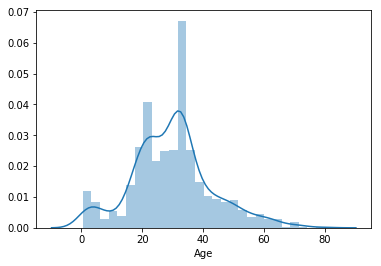

In [53]:
sns.distplot(data.Age);

Всякаш не сме.

Нека попълним двете липсващи `Embarked` с `S`, който е най-популярния.

In [54]:
data.Embarked = data.Embarked.fillna('S')
data.isnull().sum()

Survived      0
Pclass        0
Name          0
Sex           0
Age           0
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      0
Title         0
dtype: int64

Остана само `Cabin`, който решихме, че не ни интересува:

In [55]:
data = data.drop('Cabin', axis=1)

Нека си добавим и `FamilySize`:

In [56]:
data['FamilySize'] = data.Parch + data.SibSp + 1
data = data.drop(['Parch', 'SibSp'], axis=1)

Готови сме!

In [57]:
data

,Survived,Pclass,Name,Sex,Age,Ticket,Fare,Embarked,Title,FamilySize
PassengerId,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.000000,A/5 21171,7.2500,S,Mr,2
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000000,PC 17599,71.2833,C,Mrs,2
3,1,3,"Heikkinen, Miss. Laina",female,26.000000,STON/O2. 3101282,7.9250,S,Miss,1
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000000,113803,53.1000,S,Mrs,2
5,0,3,"Allen, Mr. William Henry",male,35.000000,373450,8.0500,S,Mr,1
6,0,3,"Moran, Mr. James",male,32.368090,330877,8.4583,Q,Mr,1
7,0,1,"McCarthy, Mr. Timothy J",male,54.000000,17463,51.8625,S,Mr,1
8,0,3,"Palsson, Master. Gosta Leonard",male,2.000000,349909,21.0750,S,Master,5
9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.000000,347742,11.1333,S,Mrs,3


Последна проверка:

In [58]:
data.isnull().sum()

Survived      0
Pclass        0
Name          0
Sex           0
Age           0
Ticket        0
Fare          0
Embarked      0
Title         0
FamilySize    0
dtype: int64

In [59]:
data.describe()

,Survived,Pclass,Age,Fare,FamilySize
count,891.000000,891.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.759451,32.204208,1.904602
std,0.486592,0.836071,13.278693,49.693429,1.613459
min,0.000000,1.000000,0.420000,0.000000,1.000000
25%,0.000000,2.000000,21.845638,7.910400,1.000000
50%,0.000000,3.000000,30.000000,14.454200,1.000000
75%,1.000000,3.000000,35.788991,31.000000,2.000000
max,1.000000,3.000000,80.000000,512.329200,11.000000


Всичко изглежда наред!

Нека се пробваме да потренираме модели! Но първо да си запишем новите данни някъде:

In [60]:
transformed = data.copy()

# Логистична регресия

Нека се пробваме с логистична регресия. Да припомним, моделът е същия като линейната, само че минава през сигмоид:

$$S(x) = \frac{1}{1 + e^{-x}}$$

Графиката на функцията изглежда така:

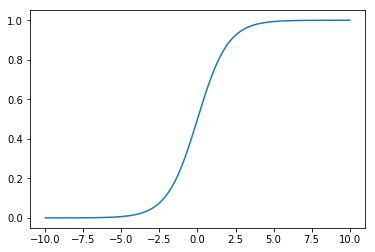

In [61]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

interval = np.linspace(-10, 10, num=1000)
plt.plot(interval, sigmoid(interval));

И формулата на модела е:

$$y = S(a_0 + a_1x_1 + a_2x_2 + \ldots + a_nx_n)$$

Където:

* $a_i$ е теглото на определен feature (и $a_0$ е константа, открита от модела)
* $x_i$ е $i$-тия feature

Понеже това е линеен модел, трябва да обработим малко данните да стигнем до числа.

In [62]:
transformed.head(6)

,Survived,Pclass,Name,Sex,Age,Ticket,Fare,Embarked,Title,FamilySize
PassengerId,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.00000,A/5 21171,7.2500,S,Mr,2
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.00000,PC 17599,71.2833,C,Mrs,2
3,1,3,"Heikkinen, Miss. Laina",female,26.00000,STON/O2. 3101282,7.9250,S,Miss,1
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.00000,113803,53.1000,S,Mrs,2
5,0,3,"Allen, Mr. William Henry",male,35.00000,373450,8.0500,S,Mr,1
6,0,3,"Moran, Mr. James",male,32.36809,330877,8.4583,Q,Mr,1


Ще one-hot encode-нем `Sex`, `Title` и `Embarked` по селския начин (без да ползваме one-hot).

In [63]:
data = transformed.copy()
data['IsMale']    = (data.Sex == 'male').astype(float)
data['IsFemale']  = (data.Sex == 'female').astype(float)
data['IsMr']      = (data.Title == 'Mr').astype(float)
data['IsMrs']     = (data.Title == 'Mrs').astype(float)
data['IsMiss']    = (data.Title == 'Miss').astype(float)
data['IsMaster']  = (data.Title == 'Master').astype(float)
data['IsRare']    = (data.Title == 'Rare').astype(float)
data['EmbarkedC'] = (data.Embarked == 'C').astype(float)
data['EmbarkedQ'] = (data.Embarked == 'Q').astype(float)
data['EmbarkedS'] = (data.Embarked == 'S').astype(float)

data = data.drop(['Sex', 'Embarked', 'Title'], axis=1)

In [64]:
data.head(10)

,Survived,Pclass,Name,Age,Ticket,Fare,FamilySize,IsMale,IsFemale,IsMr,IsMrs,IsMiss,IsMaster,IsRare,EmbarkedC,EmbarkedQ,EmbarkedS
PassengerId,,,,,,,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",22.00000,A/5 21171,7.2500,2,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.00000,PC 17599,71.2833,2,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3,1,3,"Heikkinen, Miss. Laina",26.00000,STON/O2. 3101282,7.9250,1,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.00000,113803,53.1000,2,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
5,0,3,"Allen, Mr. William Henry",35.00000,373450,8.0500,1,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
6,0,3,"Moran, Mr. James",32.36809,330877,8.4583,1,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
7,0,1,"McCarthy, Mr. Timothy J",54.00000,17463,51.8625,1,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
8,0,3,"Palsson, Master. Gosta Leonard",2.00000,349909,21.0750,5,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",27.00000,347742,11.1333,3,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


Ще изрежем и другите колони, които не ни интересуват:

In [65]:
data = data.drop(['Name', 'Ticket', 'Fare'], axis=1)
data.head(5)

,Survived,Pclass,Age,FamilySize,IsMale,IsFemale,IsMr,IsMrs,IsMiss,IsMaster,IsRare,EmbarkedC,EmbarkedQ,EmbarkedS
PassengerId,,,,,,,,,,,,,,
1,0,3,22.0,2,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,1,1,38.0,2,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3,1,3,26.0,1,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,1,1,35.0,2,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
5,0,3,35.0,1,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


Да приготвим dataset:

In [66]:
X = data.drop('Survived', axis=1)
y = data['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, stratify=y)

In [67]:
X.head()

,Pclass,Age,FamilySize,IsMale,IsFemale,IsMr,IsMrs,IsMiss,IsMaster,IsRare,EmbarkedC,EmbarkedQ,EmbarkedS
PassengerId,,,,,,,,,,,,,
1,3,22.0,2,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,1,38.0,2,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3,3,26.0,1,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,1,35.0,2,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
5,3,35.0,1,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [68]:
y.head()

PassengerId
1    0
2    1
3    1
4    1
5    0
Name: Survived, dtype: int64

Да тренираме модел!

Drumroll...

In [69]:
model = LogisticRegression()
model.fit(X_train, y_train)

print("train score:", model.score(X_train, y_train))
print("test score: ", model.score(X_test, y_test))

train score: 0.839820359281
test score:  0.80269058296


Вдигнахме резултата с около 10%! Това въобще не е за подценяване. Нека да видим какви тегла откри модела.

In [70]:
def logistic_regression_features(X, model):
    plt.figure(figsize=(12,8))
    barplot = sns.barplot(x=X.columns, y=model.coef_[0], orient='vertical')
    plt.setp(barplot.get_xticklabels(), rotation=90)
    plt.grid(True)

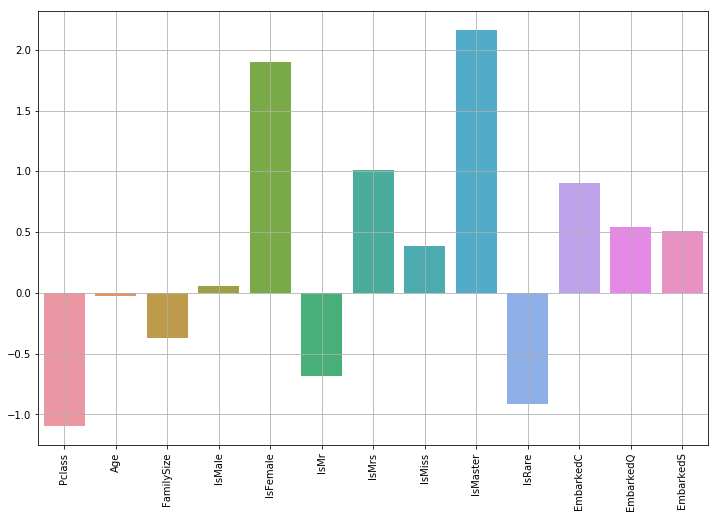

In [71]:
logistic_regression_features(X, model)

Много любопитно. Съвпада с интуицията ни. Обърнете внимане, че колкото е по-голямо число е класата, толкова по-малък е шанса за оцеляване. Аналогично и за възрастта.

# Линейни модели и непрекъснати feature-и

Линейните модели не се оправят много добре с непрекъснати feature-и, когато корелацията е линейна. Ако първа класа има точно 3 пъти по-голям шанс за оцеляване от трета, това би било ОК, но ситуацията едва ли е такава. Има аналогичен случай и за възрастта.

Нека първо да пробваме да one-hot encode-нем класата.

In [72]:
data['Class1'] = (data.Pclass == 1).astype(float)
data['Class2'] = (data.Pclass == 2).astype(float)
data['Class3'] = (data.Pclass == 3).astype(float)
data = data.drop('Pclass', axis=1)
data.head()

,Survived,Age,FamilySize,IsMale,IsFemale,IsMr,IsMrs,IsMiss,IsMaster,IsRare,EmbarkedC,EmbarkedQ,EmbarkedS,Class1,Class2,Class3
PassengerId,,,,,,,,,,,,,,,,
1,0,22.0,2,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2,1,38.0,2,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3,1,26.0,1,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4,1,35.0,2,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
5,0,35.0,1,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


Да тренираме пак:

In [73]:
X = data.drop('Survived', axis=1)
y = data['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, stratify=y)

model = LogisticRegression()
model.fit(X_train, y_train)

print("train score:", model.score(X_train, y_train))
print("test score: ", model.score(X_test, y_test))

train score: 0.839820359281
test score:  0.811659192825


Успяхме да вдигнем точността. Да видим дали бяхме прави?

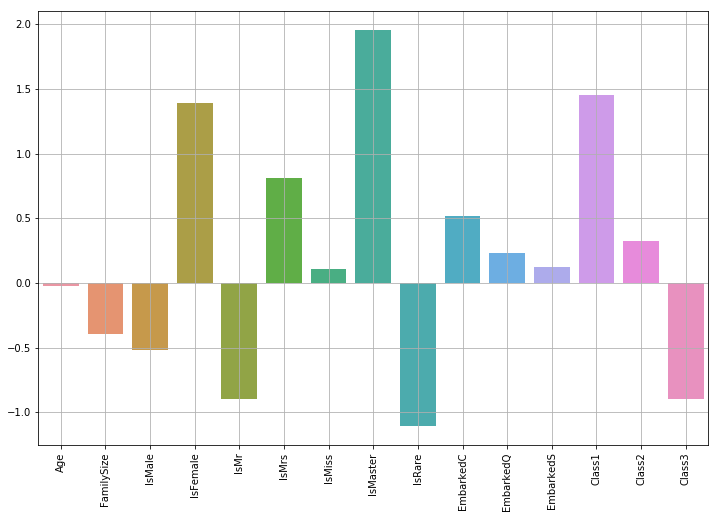

In [74]:
logistic_regression_features(X, model)

Не си личи твърде ясно от графиката, но не са съвсем на една права:

In [75]:
coefficients = model.coef_[0]
(coefficients[-2] - coefficients[-1], coefficients[-3] - coefficients[-2])

(1.2258657571072318, 1.1244030276291437)

Може да пробваме да приложим тази идея върху age – видяхме по-рано, че връзката между вързастта и оцеляваемостта не е съвсем линеайна. Може да превърнем `Age` от непрекъснат атрибут в категория и после да я one-hot encode-нем.

Това се нарича binning.

Да пробваме да ги разделим на две категори, спрямо това дали имат 18 или не:

In [76]:
data['IsChild'] = (data.Age < 18).astype(float)
data['IsAdult'] = (18 <= data.Age).astype(float)

data = data.drop('Age', axis=1)

In [77]:
data.head()

,Survived,FamilySize,IsMale,IsFemale,IsMr,IsMrs,IsMiss,IsMaster,IsRare,EmbarkedC,EmbarkedQ,EmbarkedS,Class1,Class2,Class3,IsChild,IsAdult
PassengerId,,,,,,,,,,,,,,,,,
1,0,2,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
2,1,2,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,1,1,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
4,1,2,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
5,0,1,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0


Тренираме модел:

In [78]:
X = data.drop('Survived', axis=1)
y = data['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, stratify=y)

model = LogisticRegression()
model.fit(X_train, y_train)

print("train score:", model.score(X_train, y_train))
print("test score: ", model.score(X_test, y_test))

train score: 0.841317365269
test score:  0.816143497758


Имаме подобрение! Нека да видим как изглеждат новите тегла:

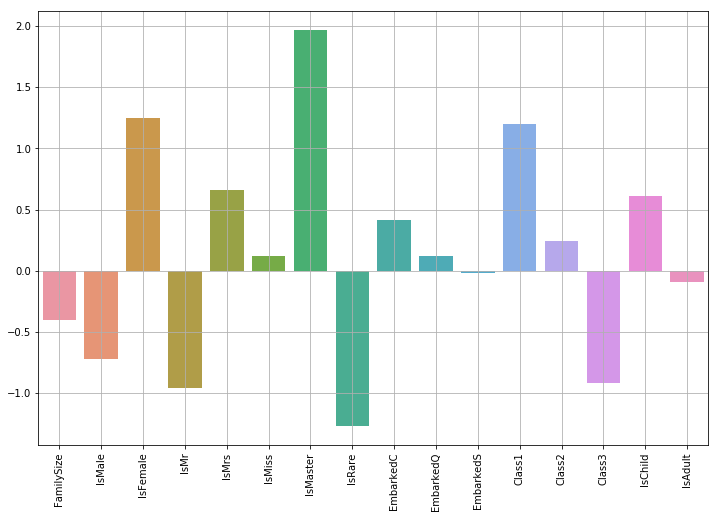

In [79]:
logistic_regression_features(X, model)

Нека да пробваме да bin-нем и размера на семейството.

In [80]:
data['IsAlone']       = (data.FamilySize == 1).astype(float)
data['IsSmallFamily'] = ((2 <= data.FamilySize) & (data.FamilySize < 5)).astype(float)
data['IsLargeFamily'] = (5 <= data.FamilySize).astype(float)

data = data.drop('FamilySize', axis=1)

In [81]:
data.head()

,Survived,IsMale,IsFemale,IsMr,IsMrs,IsMiss,IsMaster,IsRare,EmbarkedC,EmbarkedQ,EmbarkedS,Class1,Class2,Class3,IsChild,IsAdult,IsAlone,IsSmallFamily,IsLargeFamily
PassengerId,,,,,,,,,,,,,,,,,,,
1,0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2,1,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
3,1,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
4,1,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
5,0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0


In [82]:
X = data.drop('Survived', axis=1)
y = data['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, stratify=y)

model = LogisticRegression()
model.fit(X_train, y_train)

print("train score:", model.score(X_train, y_train))
print("test score: ", model.score(X_test, y_test))

train score: 0.839820359281
test score:  0.816143497758


Нямаше никаква промяна. Любопитно.

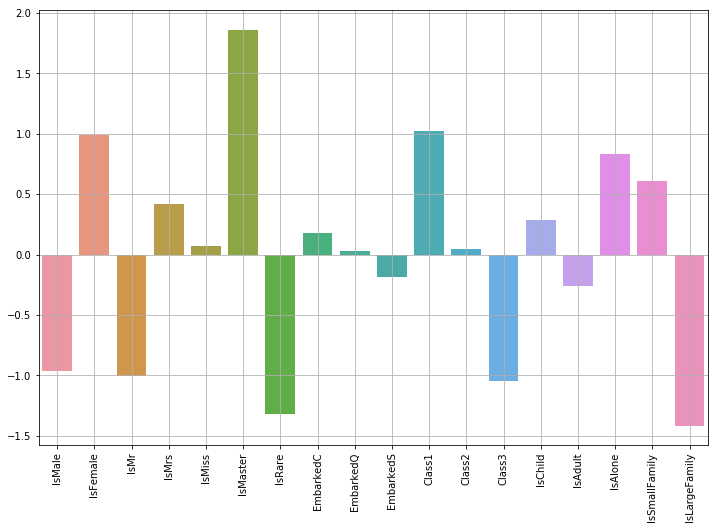

In [83]:
logistic_regression_features(X, model)

Интересно е, че `IsAlone` има по-голямо тегло от `IsSmallFamily`, което не съвпада с първоначалния ни анализ. Може би модела overfit-ва някъде. Но да спрем до тук.

Ще пробваме само с малко регуляризация.

In [84]:
for c in [0.001, 0.003, 0.006, 0.1, 0.3, 0.6, 1.0, 3.0, 6.0]:
    model = LogisticRegression(C=c)
    model.fit(X_train, y_train)
    
    print("C={:f} train: {:f} test: {:f}".format(c, model.score(X_train, y_train), model.score(X_test, y_test)))

C=0.001000 train: 0.699102 test: 0.695067
C=0.003000 train: 0.794910 test: 0.798206
C=0.006000 train: 0.793413 test: 0.789238
C=0.100000 train: 0.835329 test: 0.816143
C=0.300000 train: 0.839820 test: 0.816143
C=0.600000 train: 0.839820 test: 0.816143
C=1.000000 train: 0.839820 test: 0.816143
C=3.000000 train: 0.839820 test: 0.816143
C=6.000000 train: 0.839820 test: 0.816143


Явно стойността по подразбиране `C=1` е достатъчно добра.

# Random Forest

Веднъж видяли резултатите с логистична регресия, може да пробваме друг алгоритъм. Нека се спрем на random forest. Той няма нужда от всичкия този масаж на данни, които приложихме. Но все пак да видим какво ще стане със същите данни:

In [85]:
model = RandomForestClassifier(random_state=0).fit(X_train, y_train)
print("train score:", model.score(X_train, y_train))
print("test score: ", model.score(X_test, y_test))

train score: 0.847305389222
test score:  0.820627802691


Да пуснем и един grid search по параметри:

In [86]:
search = GridSearchCV(model, {'n_estimators': [10, 30, 50, 70, 100],
                              'max_depth': [2, 4, 6, 8, 10, 12, 15]})
search.fit(X, y)

pd.DataFrame(search.cv_results_)[['rank_test_score', 'mean_test_score', 'params']].sort_values(by='rank_test_score').head(10)

,rank_test_score,mean_test_score,params
8,1,0.832772,"{'max_depth': 4, 'n_estimators': 70}"
6,1,0.832772,"{'max_depth': 4, 'n_estimators': 30}"
7,1,0.832772,"{'max_depth': 4, 'n_estimators': 50}"
9,1,0.832772,"{'max_depth': 4, 'n_estimators': 100}"
5,5,0.827160,"{'max_depth': 4, 'n_estimators': 10}"
10,6,0.821549,"{'max_depth': 6, 'n_estimators': 10}"
12,6,0.821549,"{'max_depth': 6, 'n_estimators': 50}"
13,6,0.821549,"{'max_depth': 6, 'n_estimators': 70}"
19,9,0.819304,"{'max_depth': 8, 'n_estimators': 100}"
14,9,0.819304,"{'max_depth': 6, 'n_estimators': 100}"


Ако вземем най-добрите параметри, получаваме същия резултат за test set-а:

In [87]:
model = RandomForestClassifier(random_state=0, n_estimators=70, max_depth=4).fit(X_train, y_train)
print("train score:", model.score(X_train, y_train))
print("test score: ", model.score(X_test, y_test))

train score: 0.839820359281
test score:  0.820627802691


Май нямаше голямо значение.

Да видим какво значение е отдал алгоритъма на feature-ите:

In [88]:
def random_forest_features(model, X):
    importances = model.feature_importances_
    std = np.std([model.feature_importances_ for tree in model.estimators_],
                 axis=0)
    indices = np.argsort(importances)[::-1]

    plt.figure(figsize=(10, 10))
    plt.title("Feature importances")
    plt.bar(range(X.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
    plt.xticks(range(X.shape[1]), X.columns, rotation='vertical')
    plt.xlim([-1, X.shape[1]])
    plt.show()

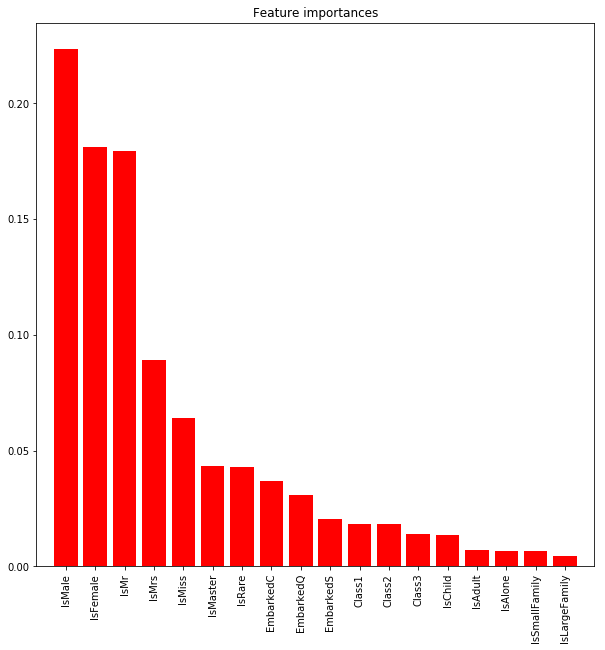

In [89]:
random_forest_features(model, X)

Казахме, че целия този binning е ненужен за RandomForest. Дали няма да се оправи по-добре ако се върнем малко по-назад?

In [90]:
data = transformed.copy()

data['Male'] = (data.Sex == 'male').astype(float)
data['Embarked'] = data.Embarked.apply(lambda x: ['C', 'S', 'Q'].index(x))
data['Title'] = data.Title.apply(lambda x: ['Mr', 'Mrs', 'Miss', 'Master', 'Rare'].index(x))

data = data.drop(['Sex', 'Name', 'Ticket', 'Fare'], axis=1)
data.head()

,Survived,Pclass,Age,Embarked,Title,FamilySize,Male
PassengerId,,,,,,,
1,0,3,22.0,1,0,2,1.0
2,1,1,38.0,0,1,2,0.0
3,1,3,26.0,1,2,1,0.0
4,1,1,35.0,1,1,2,0.0
5,0,3,35.0,1,0,1,1.0


Да тренираме отново:

In [91]:
X = data.drop('Survived', axis=1)
y = data['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, stratify=y)

model = RandomForestClassifier(random_state=0)
model.fit(X_train, y_train)

print("train score:", model.score(X_train, y_train))
print("test score: ", model.score(X_test, y_test))

train score: 0.928143712575
test score:  0.793721973094


Тук има overfitting и има шанс да намерим нещо добро ако потърсим подходящи параметри.

In [92]:
search = GridSearchCV(model, {'n_estimators': [10, 30, 50, 70, 100],
                              'max_depth': [2, 4, 6, 8, 10, 12, 15]})
search.fit(X, y)

pd.DataFrame(search.cv_results_)[['rank_test_score', 'mean_test_score', 'params']].sort_values(by='rank_test_score').head(10)

,rank_test_score,mean_test_score,params
8,1,0.835017,"{'max_depth': 4, 'n_estimators': 70}"
7,2,0.833895,"{'max_depth': 4, 'n_estimators': 50}"
6,3,0.832772,"{'max_depth': 4, 'n_estimators': 30}"
9,3,0.832772,"{'max_depth': 4, 'n_estimators': 100}"
14,5,0.829405,"{'max_depth': 6, 'n_estimators': 100}"
13,6,0.826038,"{'max_depth': 6, 'n_estimators': 70}"
0,7,0.824916,"{'max_depth': 2, 'n_estimators': 10}"
2,7,0.824916,"{'max_depth': 2, 'n_estimators': 50}"
5,7,0.824916,"{'max_depth': 4, 'n_estimators': 10}"
11,10,0.823793,"{'max_depth': 6, 'n_estimators': 30}"


In [93]:
model = RandomForestClassifier(random_state=0, max_depth=4, n_estimators=70)
model.fit(X_train, y_train)

print("train score:", model.score(X_train, y_train))
print("test score: ", model.score(X_test, y_test))

train score: 0.839820359281
test score:  0.820627802691


Същия резултат.

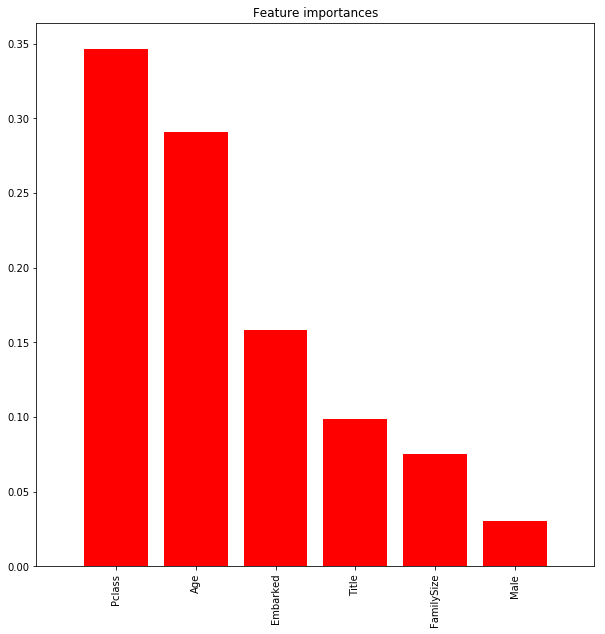

In [94]:
random_forest_features(model, X)

Нека сега да видим как щяхме да се справим с филмът Titanic!

![trio.jpeg](https://img-s-msn-com.akamaized.net/tenant/amp/entityid/AAoTC87.img?h=420&w=624&m=6&q=60&o=f&l=f&x=292&y=169)

Кой от тези тримата ще умре?

Ако поровим в IMDB, може да намерим данните за тях и да си ги трансформираме на ръка:

In [95]:
characters = pd.DataFrame([
    ['Jack Dawson',         3, 19, 1, 0, 1, 1],
    ['Rose DeWitt Bukater', 1, 16, 0, 2, 2, 0],
    ['Caledon Hockley',     1, 29, 0, 0, 2, 1]
], columns=['Name', 'Pclass', 'Age', 'Embarked', 'Title', 'FamilySize', 'Male'])
characters

,Name,Pclass,Age,Embarked,Title,FamilySize,Male
0,Jack Dawson,3,19,1,0,1,1
1,Rose DeWitt Bukater,1,16,0,2,2,0
2,Caledon Hockley,1,29,0,0,2,1


И сега да `predict`-нем:

In [96]:
model.predict(characters.drop('Name', axis=1))

array([0, 1, 0])

2 от 3! Дори може да се каже, че така е по-добре, защото Кал си заслужаваше да умре.

Нека пробваме submission в Kaggle.

За начало, трябва да взема `test.csv` и да го прекарам през всички тези трансформации. Почвам да съжалявам, че не си направих функция по-рано:

In [97]:
test = pd.read_csv('data/titanic/test.csv', index_col=['PassengerId'])

test['Title'] = test.Name.str.extract('([A-Za-z]+)\.', expand=False)
test['FamilySize'] = test.Parch + test.SibSp + 1
test['Male'] = (test.Sex == 'male').astype(float)
test['Embarked'] = test.Embarked.apply(lambda x: ['C', 'S', 'Q'].index(x))


test.loc[test.Title == 'Mlle', 'Title'] = 'Miss'
test.loc[test.Title == 'Mme', 'Title']  = 'Mrs'
test.loc[test.Title == 'Ms', 'Title']   = 'Miss'

rare_titles = ['Dr', 'Rev', 'Col', 'Major', 'Countess', 'Don', 'Jonkheer', 'Capt', 'Lady', 'Sir', 'Dona']
test.Title = test.Title.replace(rare_titles, 'Rare')

test.loc[test.Age.isnull() & (test.Title == 'Mr'), 'Age'] = age_by_title['Mr']
test.loc[test.Age.isnull() & (test.Title == 'Mrs'), 'Age'] = age_by_title['Mrs']
test.loc[test.Age.isnull() & (test.Title == 'Miss'), 'Age'] = age_by_title['Miss']
test.loc[test.Age.isnull() & (test.Title == 'Master'), 'Age'] = age_by_title['Master']
test.loc[test.Age.isnull() & (test.Title == 'Rare'), 'Age'] = age_by_title['Rare']

test['Title'] = test.Title.apply(lambda x: ['Mr', 'Mrs', 'Miss', 'Master', 'Rare'].index(x))

test = test.drop(['Sex', 'Name', 'Ticket', 'Fare', 'Cabin', 'Parch', 'SibSp'], axis=1)

test.head()

,Pclass,Age,Embarked,Title,FamilySize,Male
PassengerId,,,,,,
892,3,34.5,2,0,1,1.0
893,3,47.0,1,1,2,0.0
894,2,62.0,2,0,1,1.0
895,3,27.0,1,0,1,1.0
896,3,22.0,1,1,3,0.0


Да си генерирам с CSV файл:

In [98]:
predictions = model.predict(test)
frame = pd.DataFrame({
    'PassengerId': pd.read_csv('data/titanic/test.csv').PassengerId,
    'Survived': predictions
})
frame = frame.set_index('PassengerId')
frame.to_csv('~/Desktop/predictions.csv')
frame.head()

,Survived
PassengerId,
892,0
893,1
894,0
895,0
896,1


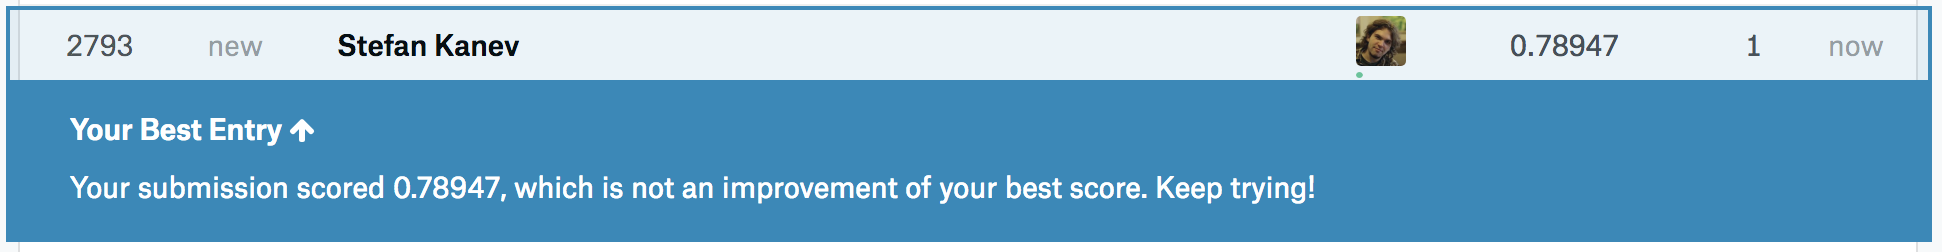

Два въпроса:

* Защо не съм по-нагоре? (2793/8677)
* Защо точността ми е по-малка?

# Въпроси?